In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip -q uninstall -y numpy jax jaxlib opencv-python opencv-python-headless opencv-contrib-python shap pytensor
!pip -q install "numpy==1.26.4"

!pip -q install \
  faiss-cpu==1.8.0.post1 \
  sentence-transformers==2.7.0 \
  transformers==4.41.2 \
  accelerate==0.30.1 \
  bitsandbytes==0.43.1 \
  nvidia-ml-py3 \
  pandas \
  matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.27.1 requires pytensor<2.38.0,>=2.37.0, which is not installed.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
optax 0.2.7 requires jax>=0.5.3, which is not installed.
optax 0.2.7 requires jaxlib>=0.5.3, which is not installed.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
orbax-checkpoint 0.11.32 requires jax>=0.6.0, which is not installed.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installed.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
flax 0.11.2 requires jax>=0.6.0, which is not installed.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have n

In [5]:
import os, re, json, time, math, threading
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import faiss

from sentence_transformers import SentenceTransformer, CrossEncoder
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

from pynvml import (
    nvmlInit, nvmlShutdown, nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetName, nvmlDeviceGetPowerUsage,
    nvmlDeviceGetUtilizationRates, nvmlDeviceGetMemoryInfo
)

print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

nvmlInit()
_handle = nvmlDeviceGetHandleByIndex(0)
print("NVML device:", nvmlDeviceGetName(_handle))

Torch: 2.9.0+cu128 CUDA available: True
GPU: Tesla T4
NVML device: b'Tesla T4'


In [6]:
BASE_DIR = Path("/content/drive/MyDrive/PerfWattLab_RAG")
INDEX_DIR = BASE_DIR / "index"
OUT_DIR = BASE_DIR / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

index_path = INDEX_DIR / "faiss.index"
chunks_path = INDEX_DIR / "chunks.json"

assert index_path.exists(), f"Missing {index_path}"
assert chunks_path.exists(), f"Missing {chunks_path}"

index = faiss.read_index(str(index_path))
with open(chunks_path, "r") as f:
    chunks = json.load(f)

print("Loaded FAISS ntotal:", index.ntotal)
print("Loaded chunks:", len(chunks))
print("Example chunk id:", chunks[0]["chunk_id"])

Loaded FAISS ntotal: 5
Loaded chunks: 5
Example chunk id: doc1.txt::chunk0


In [7]:
embed_model_name = "sentence-transformers/all-MiniLM-L6-v2"
reranker_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"

embedder = SentenceTransformer(embed_model_name)
if torch.cuda.is_available():
    embedder = embedder.to("cuda")

reranker = CrossEncoder(reranker_name, device="cuda" if torch.cuda.is_available() else "cpu")

gen_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(gen_model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    gen_model_name,
    device_map="auto",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)
model.eval()

gen_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

print("Embedder:", embed_model_name)
print("Reranker:", reranker_name)
print("Generator:", gen_model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedder: sentence-transformers/all-MiniLM-L6-v2
Reranker: cross-encoder/ms-marco-MiniLM-L-6-v2
Generator: TinyLlama/TinyLlama-1.1B-Chat-v1.0


In [8]:
def retrieve(query: str, top_k: int = 10):
    t0 = time.perf_counter()
    q_emb = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
    scores, idxs = index.search(q_emb, top_k)
    t1 = time.perf_counter()

    results = []
    for score, i in zip(scores[0], idxs[0]):
        c = chunks[int(i)]
        results.append({
            "chunk_id": c["chunk_id"],
            "doc_id": c["doc_id"],
            "text": c["text"],
            "score": float(score),
        })
    return results, (t1 - t0) * 1000.0


def rerank(query: str, retrieved, top_k: int = 5):
    t0 = time.perf_counter()
    pairs = [(query, r["text"]) for r in retrieved]
    scores = reranker.predict(pairs)
    for r, s in zip(retrieved, scores):
        r["rerank_score"] = float(s)
    reranked = sorted(retrieved, key=lambda x: x["rerank_score"], reverse=True)[:top_k]
    t1 = time.perf_counter()
    return reranked, (t1 - t0) * 1000.0


def build_prompt(query: str, context_chunks):
    context = "\n\n".join([f"[{i+1}] {c['text']}" for i, c in enumerate(context_chunks)])
    prompt = f"""You are a helpful assistant. Use the context to answer the question.
If the context is not enough, say you are not sure.

Context:
{context}

Question:
{query}

Answer:"""
    return prompt

In [9]:
def count_new_tokens(prompt: str, full_text: str):
    p = tokenizer(prompt, return_tensors="pt")["input_ids"][0]
    o = tokenizer(full_text, return_tensors="pt")["input_ids"][0]
    return max(int(o.shape[0] - p.shape[0]), 0)


def generate_with_pipeline(prompt: str, max_new_tokens: int):
    t0 = time.perf_counter()
    out = gen_pipe(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        temperature=0.0,
        return_full_text=True,
    )[0]["generated_text"]
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t1 = time.perf_counter()

    gen_tokens = count_new_tokens(prompt, out)
    secs = max(t1 - t0, 1e-9)
    tps = gen_tokens / secs
    return out, (t1 - t0) * 1000.0, gen_tokens, tps


@torch.inference_mode()
def generate_direct(prompt: str, max_new_tokens: int):
    t0 = time.perf_counter()

    inputs = tokenizer(prompt, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

    out_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        use_cache=True,
    )

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t1 = time.perf_counter()

    out = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    gen_tokens = int(out_ids.shape[1] - inputs["input_ids"].shape[1])
    secs = max(t1 - t0, 1e-9)
    tps = gen_tokens / secs
    return out, (t1 - t0) * 1000.0, gen_tokens, tps

In [10]:
class PowerSampler:
    def __init__(self, handle, interval_s=0.2):
        self.handle = handle
        self.interval_s = interval_s
        self._stop = threading.Event()
        self.rows = []
        self.t0 = None
        self.thread = None

    def start(self):
        self.rows = []
        self._stop.clear()
        self.t0 = time.perf_counter()
        self.thread = threading.Thread(target=self._run, daemon=True)
        self.thread.start()

    def stop(self):
        self._stop.set()
        if self.thread is not None:
            self.thread.join()

    def _run(self):
        while not self._stop.is_set():
            t = time.perf_counter()
            rel_s = t - self.t0

            power_mw = nvmlDeviceGetPowerUsage(self.handle)
            util = nvmlDeviceGetUtilizationRates(self.handle)
            mem = nvmlDeviceGetMemoryInfo(self.handle)

            self.rows.append({
                "t_rel_s": rel_s,
                "power_w": power_mw / 1000.0,
                "gpu_util_pct": int(util.gpu),
                "mem_util_pct": int(util.memory),
                "mem_used_mb": mem.used / (1024**2),
            })

            time.sleep(self.interval_s)

In [11]:
def integrate_energy_j(samples_df: pd.DataFrame, t_start: float, t_end: float):
    if t_end <= t_start:
        return 0.0

    df = samples_df.sort_values("t_rel_s").reset_index(drop=True)

    # Keep a small buffer around the window
    df = df[(df["t_rel_s"] >= t_start - 1.0) & (df["t_rel_s"] <= t_end + 1.0)].copy()
    if len(df) < 2:
        return 0.0

    t = df["t_rel_s"].to_numpy()
    p = df["power_w"].to_numpy()

    energy_j = 0.0
    for i in range(len(df) - 1):
        seg_t0 = max(t[i], t_start)
        seg_t1 = min(t[i + 1], t_end)
        if seg_t1 > seg_t0:
            dt = seg_t1 - seg_t0
            energy_j += float(p[i]) * dt

    return energy_j

In [12]:
def rag_once(query: str, gen_mode: str, max_new_tokens: int):
    t0 = time.perf_counter()

    retrieved, t_retr = retrieve(query, top_k=10)
    reranked, t_rer = rerank(query, retrieved, top_k=5)
    prompt = build_prompt(query, reranked)

    if gen_mode == "pipeline":
        text, t_gen, gen_tokens, tps = generate_with_pipeline(prompt, max_new_tokens=max_new_tokens)
    elif gen_mode == "direct":
        text, t_gen, gen_tokens, tps = generate_direct(prompt, max_new_tokens=max_new_tokens)
    else:
        raise ValueError("gen_mode must be pipeline or direct")

    t1 = time.perf_counter()
    total_ms = (t1 - t0) * 1000.0

    return {
        "t_start_rel_s": None,   # filled by caller
        "t_end_rel_s": None,     # filled by caller
        "query": query,
        "retrieval_ms": float(t_retr),
        "rerank_ms": float(t_rer),
        "generation_ms": float(t_gen),
        "total_ms": float(total_ms),
        "gen_tokens": int(gen_tokens),
        "toks_per_sec": float(tps),
        "answer_preview": text[-300:],
    }


def run_config(name: str, gen_mode: str, max_new_tokens: int, queries: list):
    sampler = PowerSampler(_handle, interval_s=0.2)

    # Warmup to stabilize kernels and caching
    _ = rag_once(queries[0], gen_mode=gen_mode, max_new_tokens=max_new_tokens)
    _ = rag_once(queries[1], gen_mode=gen_mode, max_new_tokens=max_new_tokens)

    sampler.start()
    run_rows = []

    for q in queries:
        t_start = time.perf_counter() - sampler.t0
        row = rag_once(q, gen_mode=gen_mode, max_new_tokens=max_new_tokens)
        t_end = time.perf_counter() - sampler.t0
        row["t_start_rel_s"] = float(t_start)
        row["t_end_rel_s"] = float(t_end)
        row["config"] = name
        run_rows.append(row)

    sampler.stop()

    power_df = pd.DataFrame(sampler.rows)
    runs_df = pd.DataFrame(run_rows)

    # Compute energy per query using time aligned power samples
    energies = []
    for r in run_rows:
        e = integrate_energy_j(power_df, r["t_start_rel_s"], r["t_end_rel_s"])
        energies.append(e)

    runs_df["energy_j"] = energies
    runs_df["avg_w_during_query"] = runs_df["energy_j"] / ((runs_df["t_end_rel_s"] - runs_df["t_start_rel_s"]).clip(lower=1e-9))

    # Energy per token
    runs_df["energy_j_per_token"] = runs_df["energy_j"] / runs_df["gen_tokens"].clip(lower=1)

    return power_df, runs_df

In [13]:
queries = [
    "What is CUDA and why is it useful?",
    "What is Triton Inference Server used for?",
    "Why do people use FAISS in RAG systems?",
    "What are Prometheus and Grafana used for?",
    "Explain dynamic batching in simple terms.",
]
queries = queries * 6  # 30 total
print("Total queries:", len(queries))

MAX_NEW_TOKENS = 160

power_base, runs_base = run_config(
    name="baseline_pipeline",
    gen_mode="pipeline",
    max_new_tokens=MAX_NEW_TOKENS,
    queries=queries
)

power_opt, runs_opt = run_config(
    name="optimized_direct",
    gen_mode="direct",
    max_new_tokens=MAX_NEW_TOKENS,
    queries=queries
)

print("Done.")

Total queries: 30


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Done.


In [14]:
out_power_base = OUT_DIR / "day4_power_samples_baseline.csv"
out_power_opt = OUT_DIR / "day4_power_samples_optimized.csv"
out_runs = OUT_DIR / "day4_runs_with_energy.csv"

power_base.to_csv(out_power_base, index=False)
power_opt.to_csv(out_power_opt, index=False)

all_runs = pd.concat([runs_base, runs_opt], ignore_index=True)
all_runs.to_csv(out_runs, index=False)

print("Saved:", out_power_base)
print("Saved:", out_power_opt)
print("Saved:", out_runs)

Saved: /content/drive/MyDrive/PerfWattLab_RAG/outputs/day4_power_samples_baseline.csv
Saved: /content/drive/MyDrive/PerfWattLab_RAG/outputs/day4_power_samples_optimized.csv
Saved: /content/drive/MyDrive/PerfWattLab_RAG/outputs/day4_runs_with_energy.csv


In [15]:
def pctl(xs, p):
    xs = np.asarray(xs, dtype=np.float64)
    return float(np.percentile(xs, p))

summary = []
for cfg, df in all_runs.groupby("config"):
    summary.append({
        "config": cfg,
        "n_queries": int(len(df)),
        "p50_total_ms": pctl(df["total_ms"], 50),
        "p95_total_ms": pctl(df["total_ms"], 95),
        "p50_toks_per_sec": pctl(df["toks_per_sec"], 50),
        "mean_power_w_overall": float(np.mean(df["avg_w_during_query"])),
        "p50_energy_j_per_query": pctl(df["energy_j"], 50),
        "p95_energy_j_per_query": pctl(df["energy_j"], 95),
        "p50_energy_j_per_token": pctl(df["energy_j_per_token"], 50),
    })

summary_df = pd.DataFrame(summary).sort_values("config")
out_summary = OUT_DIR / "day4_summary.csv"
summary_df.to_csv(out_summary, index=False)

summary_df

,config,n_queries,p50_total_ms,p95_total_ms,p50_toks_per_sec,mean_power_w_overall,p50_energy_j_per_query,p95_energy_j_per_query,p50_energy_j_per_token
0,baseline_pipeline,30,3274.424906,5508.967052,33.615674,57.069263,191.531097,296.913899,1.795300
1,optimized_direct,30,2763.823452,4951.393188,38.335920,64.867223,185.345551,312.458053,1.755398


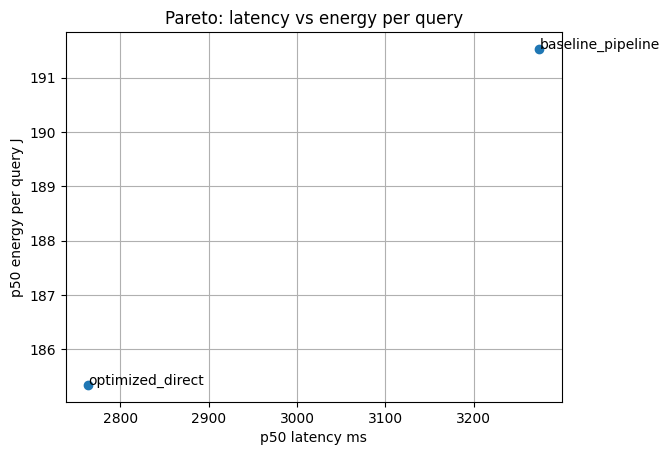

In [16]:
x = summary_df["p50_total_ms"].to_numpy()
y = summary_df["p50_energy_j_per_query"].to_numpy()
labels = summary_df["config"].tolist()

plt.figure()
plt.scatter(x, y)

for xi, yi, lab in zip(x, y, labels):
    plt.text(xi, yi, lab)

plt.xlabel("p50 latency ms")
plt.ylabel("p50 energy per query J")
plt.title("Pareto: latency vs energy per query")
plt.grid(True)
plt.show()

In [17]:
limitations = """
Colab power measurement limitations

1. NVML power is GPU board power reported by the driver, not wall power.
2. Sampling at 5 Hz can miss short spikes, so energy is an approximation.
3. Colab is a shared environment and clocks can vary due to DVFS and background load.
4. CPU and system power are not included, only GPU.
5. Timing alignment is best effort based on host timestamps, so there is some jitter.
"""
print(limitations)


Colab power measurement limitations

1. NVML power is GPU board power reported by the driver, not wall power.
2. Sampling at 5 Hz can miss short spikes, so energy is an approximation.
3. Colab is a shared environment and clocks can vary due to DVFS and background load.
4. CPU and system power are not included, only GPU.
5. Timing alignment is best effort based on host timestamps, so there is some jitter.

